<a href="https://colab.research.google.com/github/debbiedebdeb/Algorithm/blob/master/E_commerce_%EA%B3%A0%EA%B0%9D_%EA%B1%B0%EB%9E%98_%EB%8D%B0%EC%9D%B4%ED%84%B0_RFM%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 고객 거래 데이터를 활용한 RMF 분석

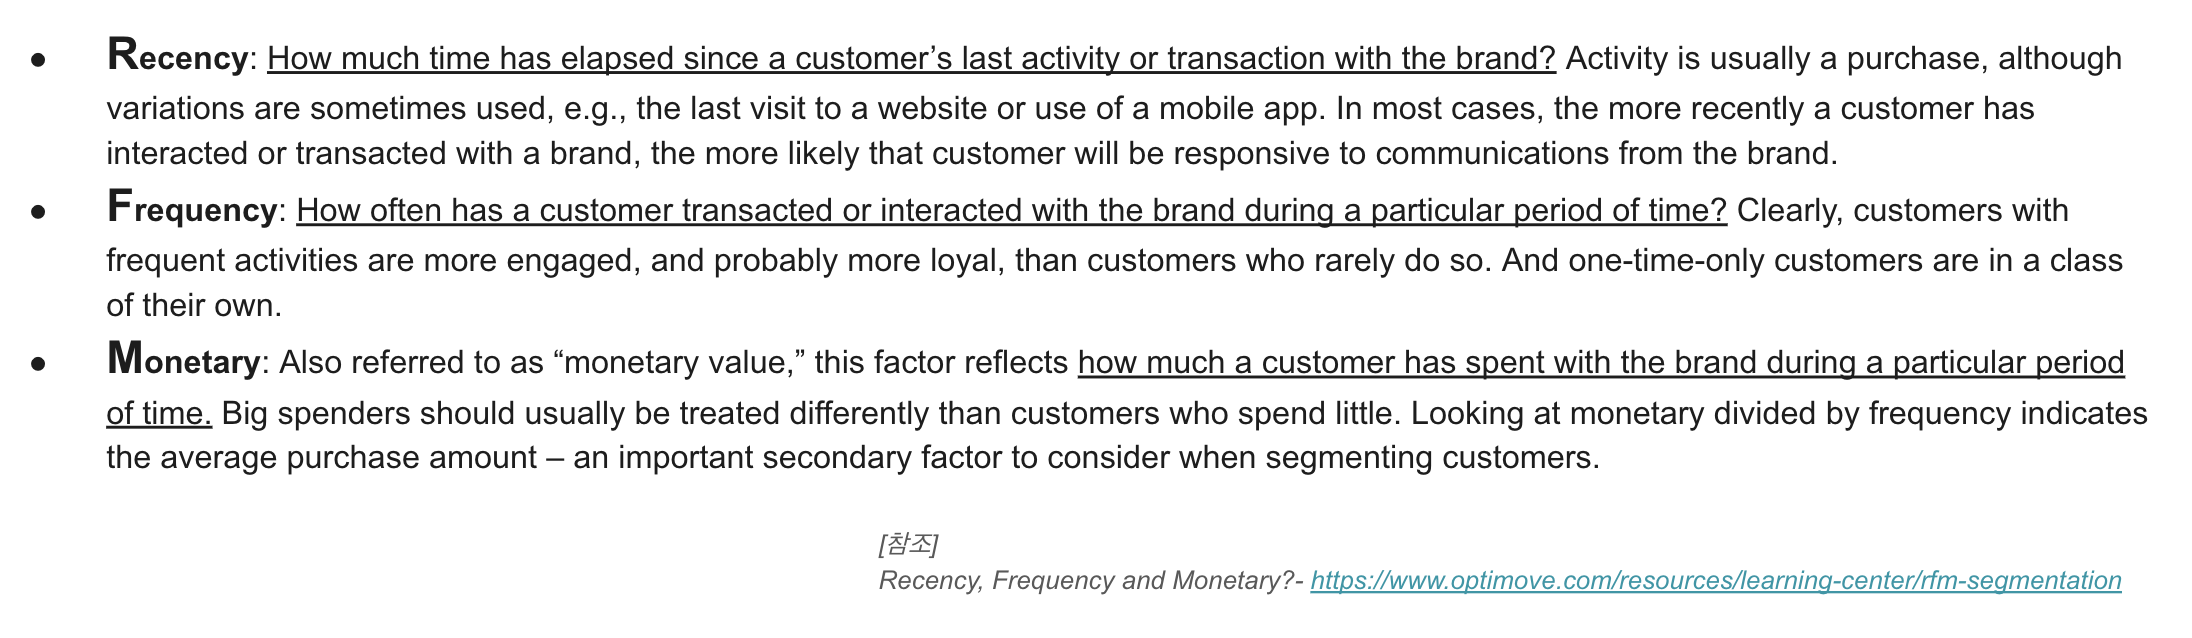

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
from sklearn.model_selection import train_test_split 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action = 'ignore')
pd.set_option('display.max_columns', None)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

## 데이터 생성하기 

In [ ]:
# 전처리한 고객 거래 데이터 불러오기 
stats_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/나혼자 KAGGLE/E-commerce DA/고객거래데이터_전처리.xlsx')
stats_df.head(1)

,user_id,membership_type,total_order_cnt,total_cost,avg_coupon_amt,avg_point_amt,weekly_order_cnt,monthly_order_cnt,avg_cost,avg_item_cost,last_date,dayofRecency
0,q3qlSo1pvyacJoy,100,1,23800,0.0,0.0,1.0,1.0,23800.0,0.0,2020-04-05,96


#### [User stat 컬럼 명세서]  

컬럼명 | 설명
--- | ---
user_id | 고객 고유 ID
membership_type | 멤버십 타입 (100:비회원, 300-500:정회원)
total_order_cnt | 총 거래건수
total_cost | 총 거래금액
avg_coupon_amt | 평균 쿠폰사용 금액
avg_point_amt | 평균 포인트사용 금액
weekly_order_cnt | 주평균 거래건수
monthly_order_cnt | 주평균 거래건수
avg_cost | 평균 거래금액
avg_item_cost | 평균 상품금액
last_date | 마지막 거래일자 (yyyy-mm-dd)  
dayofRecency | 마지막 거래 일자 - 2019년12월31일

In [ ]:
stats_df.columns

Index(['user_id', 'membership_type', 'total_order_cnt', 'total_cost',
       'avg_coupon_amt', 'avg_point_amt', 'weekly_order_cnt',
       'monthly_order_cnt', 'avg_cost', 'avg_item_cost', 'last_date',
       'dayofRecency'],
      dtype='object')

## RFM 분석용 DF 만들기 

In [ ]:
# Recency : 가장 마지막 방문/결제한 날짜를 기준으로 얼마나 지났느냐 DayofRecency (*큰 값에 더 높은 값을 주기위해 과거시간으로 역산함)
# Frequency : 얼마나 자주 방문(거래)했느냐 total_order_cnt
# Moneytary : 얼마나 많이 썼느냐  total_cost
rfm_df = stats_df[['user_id', 'membership_type', 'dayofRecency', 'total_order_cnt', 'total_cost']]
rfm_df.rename(columns ={'dayofRecency' : 'R','total_order_cnt' : 'F', 'total_cost' : 'M' }, inplace = True )
rfm_df.head(1)

,user_id,membership_type,R,F,M
0,q3qlSo1pvyacJoy,100,96,1,23800


## 정규화 진행하기

: 단위가 다르기때문에, 각 컬럼별 특성을 반영해 Custom Normalization 진행 (이커머스 데이터 성향에 맞게 정규화 필요) 

In [ ]:
rfm_df.describe()

,membership_type,R,F,M
count,3412.000000,3412.000000,3412.000000,3.412000e+03
mean,153.575615,84.283118,9.055686,3.516288e+05
std,106.964154,63.346044,21.780867,1.068412e+06
min,100.000000,1.000000,1.000000,0.000000e+00
25%,100.000000,28.750000,1.000000,2.500000e+04
50%,100.000000,67.000000,1.000000,3.700000e+04
75%,100.000000,154.000000,2.000000,6.003750e+04
max,500.000000,182.000000,248.000000,2.825470e+07


### R column 정규화 

In [ ]:
# Q-cut으로 동일 데이터 수로 점수를 할당 
# 단점 : 동일한 숫자가 겹쳐질 경우 나누기 어려움 

# 1등부터 꼴등까지 등수 매기기
rfm_df['R_rank'] = rfm_df['R'].rank(method = 'first') 

# 5개의 등금 구간으로 나누기 
rfm_df['R_score'] = pd.qcut(rfm_df['R_rank'], 5, labels = [1,2,3,4,5])
rfm_df.head(5)

,user_id,membership_type,R,F,M,R_rank,R_score
0,q3qlSo1pvyacJoy,100,96,1,23800,2117.0,4
1,JRy7QRK0UMFP81X,100,17,1,23000,584.0,1
2,Z0IzeePX3LwQ2Ea,100,136,1,24000,2414.0,4
3,EoRzAGlei59fugN,100,62,1,22000,1608.0,3
4,zgQJlOYlFURl6ev,300,175,19,561200,2878.0,5


In [ ]:
# 각 스코어의 분포 보기  
rfm_df.groupby('R_score').agg(['count', 'mean', 'std', 'min', 'max'])['R']

,count,mean,std,min,max
R_score,,,,,
1,683,9.767204,5.216147,1,19
2,682,34.763930,8.390173,19,50
3,682,68.139296,11.391689,50,88
4,682,130.890029,24.866066,89,168
5,683,177.827233,3.990387,168,182


In [ ]:
# 다른 방법으로 cut 해보기 : 2019년 12월 31일 기준으로 마지막 거래일이 얼마나 지났는지 * 숫자가 클수록 최근 고객 
# 비즈니스 특성을 반영한 구간으로 지정 
rfm_df['R_score2'] = pd.cut(rfm_df['R'], [0,30,90,120,180,1000], 
                            labels = [1,2,3,4,5])
rfm_df.groupby('R_score2').agg(['count' ,'mean', 'std', 'min', 'max'])['R']

,count,mean,std,min,max
R_score2,,,,,
1,909,13.564356,8.205476,1,30
2,1163,57.398108,17.361814,31,90
3,234,105.222222,8.959241,91,120
4,868,162.026498,17.521264,121,180
5,238,181.634454,0.482598,181,182


### F column 정규화 

* describe를 봤을 때 F는 1~2가 75% 차지 

In [ ]:
rfm_df.describe()

,membership_type,R,F,M,R_rank
count,3412.000000,3412.000000,3412.000000,3.412000e+03,3412.000000
mean,153.575615,84.283118,9.055686,3.516288e+05,1706.500000
std,106.964154,63.346044,21.780867,1.068412e+06,985.103886
min,100.000000,1.000000,1.000000,0.000000e+00,1.000000
25%,100.000000,28.750000,1.000000,2.500000e+04,853.750000
50%,100.000000,67.000000,1.000000,3.700000e+04,1706.500000
75%,100.000000,154.000000,2.000000,6.003750e+04,2559.250000
max,500.000000,182.000000,248.000000,2.825470e+07,3412.000000


In [ ]:
# cut 으로 custom 점수 할당하기 

rfm_df['F_score'] = pd.cut(rfm_df['F'], [0,1,10,50,100,1000], labels =[1,2,3,4,5])
rfm_df.head(1)

,user_id,membership_type,R,F,M,R_rank,R_score,R_score2,F_score
0,q3qlSo1pvyacJoy,100,96,1,23800,2117.0,4,3,1


In [ ]:
# label 별 agg 확인해보기 
rfm_df.groupby('F_score')['F'].agg(['count', 'mean', 'std', 'min', 'max'])

# > 1이 많다보니 1_score가 상대적으로 정말 많다 

,count,mean,std,min,max
F_score,,,,,
1,2331,1.000000,0.000000,1,1
2,469,3.260128,2.339856,2,10
3,435,27.588506,11.003073,11,50
4,139,69.906475,12.422451,51,97
5,38,140.000000,39.970935,101,248


### M column

In [ ]:
# 분위수 확인 
rfm_df["M"].quantile([0,0.3,0.5,0.7,0.9,1.0]) #분위수 확인 

# 70%까지 5만원이 안되는데, 그 이후 값이 갑자기 엄청 커짐 >> skewed 된 데이터 

0.0           0.0
0.3       27000.0
0.5       37000.0
0.7       48146.0
0.9     1128430.0
1.0    28254700.0
Name: M, dtype: float64

In [ ]:
# cut 으로 나누기 
rfm_df['M_score'] = pd.cut(rfm_df['M'], 
                           [-1,  30000, 100000, 1000000, 5000000, 30000000000], 
                           labels = [1,2,3,4,5])
rfm_df.groupby('M_score').agg(['count', 'mean', 'std', 'min', 'max'])['M']

,count,mean,std,min,max
M_score,,,,,
1,1274,2.142846e+04,5.943787e+03,0,30000
2,1421,4.364777e+04,1.200348e+04,30100,99400
3,340,5.457504e+05,2.569712e+05,111500,998610
4,348,1.988578e+06,8.347297e+05,1001200,4293420
5,29,8.029441e+06,5.002624e+06,5042710,28254700


## RFM Clustering 

In [ ]:
X = rfm_df[['R_score', 'F_score', 'M_score']]
y = rfm_df['membership_type']

# train, test  나누기 
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2)
len(train_x), len(test_x)

(2729, 683)

### 최적의 K 찾기 (train_set)

In [ ]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
from yellowbrick.cluster import SilhouetteVisualizer

In [ ]:
distortions = []
k_range = range(1,11)

for i in k_range : 
    km = KMeans(n_clusters = i)
    km.fit(train_x)
    distortions.append(km.inertia_)

print(distortions)

[10413.953829241438, 4381.879015659235, 2096.7058397494457, 1726.1209688195963, 1445.8684614526428, 1270.7901684919834, 1024.5249209474714, 897.0807549765395, 751.3939744446465, 628.0614567703062]


In [ ]:
kneedle = KneeLocator(x = k_range, y = distortions , curve = 'convex', direction = 'decreasing')
print(f'최적의 k : {round(kneedle.elbow, 3)}')
print(f'최적의 k의 y값 : { round(kneedle.elbow_y, 3)}')

최적의 k : 3
최적의 k의 y값 : 2096.706


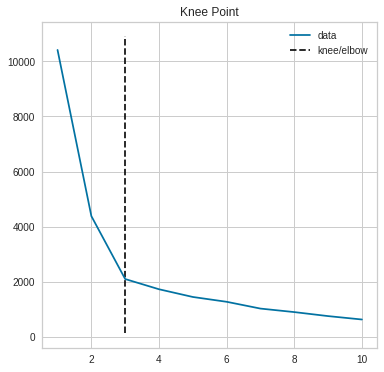

In [ ]:
# 시각화
kneedle.plot_knee() # >> 3

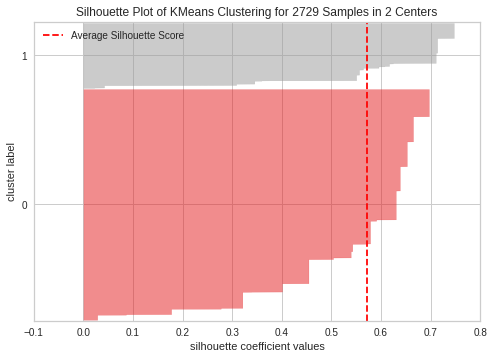

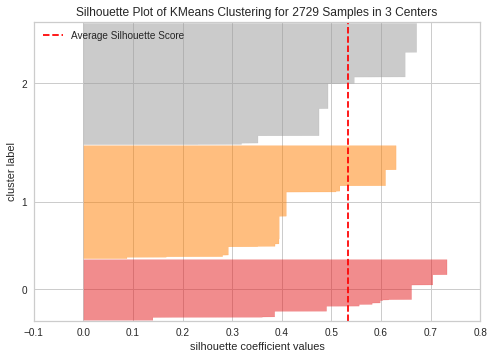

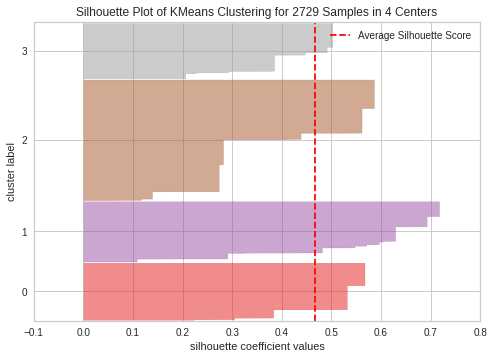

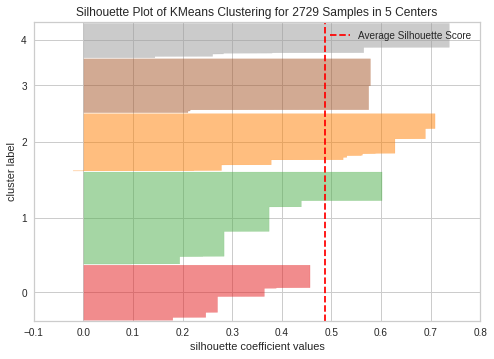

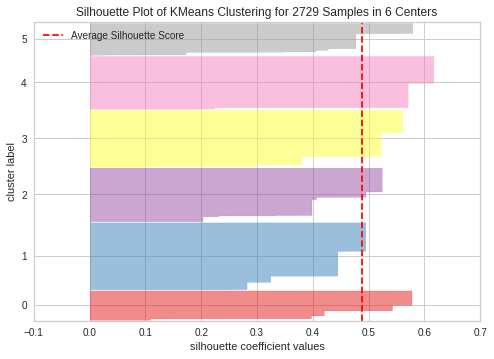

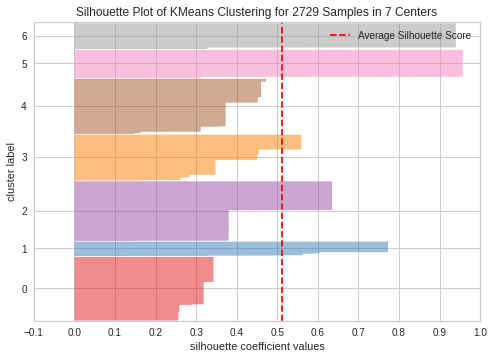

In [ ]:
# 실루엣계수로 확인해보기 
k_range = range(2,8)
for i in k_range : 
    km = KMeans(n_clusters = i , init = 'k-means++')
    visualizer = SilhouetteVisualizer(km)
    visualizer.fit(train_x)
    visualizer.poof()

# 0.5 이상에 균등하게 배분된 k =3 가 최적으로 보임 

In [ ]:
model = KMeans(n_clusters = 3)
km = model.fit(train_x)
km.labels_


rfm_train_df = train_x.copy()
rfm_train_df[['R_score', 'F_score', 'M_score']] = rfm_train_df[['R_score', 'F_score', 'M_score']].astype('int')
rfm_train_df['km_label'] = km.labels_

In [ ]:
rfm_train_df

,R_score,F_score,M_score,km_label
938,2,1,1,0
3118,4,3,3,1
2761,2,1,2,0
1623,4,1,1,2
3375,5,2,3,1
...,...,...,...,...
2327,2,1,2,0
2883,5,4,4,1
1079,2,1,2,0
151,5,3,3,1


In [ ]:
# label 별 평균값과 개수 확인하기 
train_cluster_df = rfm_train_df.groupby('km_label').mean()
train_cluster_df['cnt'] =  rfm_train_df['km_label'].value_counts()
train_cluster_df 

,R_score,F_score,M_score,cnt
km_label,,,,
0,1.503565,1.127451,1.560606,1122
1,4.802139,3.146168,3.568627,561
2,3.577438,1.161568,1.503824,1046


### Test data 예측 

In [ ]:
test_x.head()

,R_score,F_score,M_score
486,4,2,2
3157,3,1,1
2064,5,3,4
658,4,2,1
948,2,1,2


In [ ]:
rfm_test_df = test_x.copy()
rfm_test_df[['R_score', 'F_score', 'M_score']] = rfm_test_df[['R_score', 'F_score', 'M_score']].astype('int')
rfm_test_df['km_label'] = km.predict(test_x)

test_cluster_df = rfm_test_df.groupby('km_label').mean()
test_cluster_df['cnt'] = rfm_test_df['km_label'].value_counts()
test_cluster_df.head(3)

,R_score,F_score,M_score,cnt
km_label,,,,
0,1.481481,1.082305,1.563786,243
1,4.771812,3.234899,3.583893,149
2,3.580756,1.134021,1.487973,291


test_set을 clustering 했을 때 test_set과 비슷하게 군집해줌 

### 시각화 

In [ ]:
label_color = { 0 : 'red', 1 : 'green', 2 : 'blue', 3 : 'yello', 4 : 'orange'}
rfm_test_df['km_label_color'] = rfm_test_df['km_label'].map(label_color)
rfm_test_df.head()

,R_score,F_score,M_score,km_label,km_label_color
486,4,2,2,2,blue
3157,3,1,1,2,blue
2064,5,3,4,1,green
658,4,2,1,2,blue
948,2,1,2,0,red


In [ ]:
# 3d 그래프 그려보기 
fig = go.Figure(data = [go.Scatter3d( x = rfm_test_df['R_score'], 
                                     y =  rfm_test_df['F_score'], 
                                     z =  rfm_test_df['M_score'], 
                                     mode = 'markers', 
                                     marker = dict(color =rfm_test_df['km_label_color'], opacity = 0.5 )
                                     )])

fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0), 
                  scene = dict( 
                      xaxis = dict(
                          title = 'R_score'), 
                          yaxis = dict(
                              title = 'F_score'
                          ) ,
                          zaxis = dict(
                              title = "M_score"
                          ) 
                      )
                  )
fig.show(showlegend=True)

In [ ]:
trained_rfm_df = pd.concat([rfm_train_df, rfm_test_df])
trained_rfm_df.head(3)

labeled_df = stats_df.join(trained_rfm_df, how = 'inner')

labeled_df.drop('km_label_color', axis =1 , inplace = True)

In [ ]:
# 원본데이터에 결과 합치기 
labeled_df.head(2)

,user_id,membership_type,total_order_cnt,total_cost,avg_coupon_amt,avg_point_amt,weekly_order_cnt,monthly_order_cnt,avg_cost,avg_item_cost,last_date,dayofRecency,R_score,F_score,M_score,km_label
0,q3qlSo1pvyacJoy,100,1,23800,0.0,0.0,1.0,1.0,23800.0,0.0,2020-04-05,96,4,1,1,2
1,JRy7QRK0UMFP81X,100,1,23000,0.0,0.0,1.0,1.0,23000.0,10000.0,2020-01-17,17,1,1,1,0


# 고객 군집화를 통해 멤버십 등급의 특징 파악 

In [ ]:
# 그룹을 구분지을 변수 선택하고 , 그룹별로 비교하기 

labeled_df.groupby('km_label').agg(
    user_cnt = ('user_id', 'count'), 
    avg_total_order_cnt = ('total_order_cnt', 'mean'), 
    avg_cost = ('avg_cost', 'mean'), 
    avg_dayofRecency = ('dayofRecency', 'mean'), 
    avg_weekly_order_cnt = ('weekly_order_cnt', 'mean'), 
    avg_coupon_amt = ('avg_point_amt', 'mean')
)

,user_cnt,avg_total_order_cnt,avg_cost,avg_dayofRecency,avg_weekly_order_cnt,avg_coupon_amt
km_label,,,,,,
0,1365,1.143590,32426.222212,22.256410,1.046764,-67.710623
1,705,39.057746,40068.213887,172.278873,2.101490,-1.666048
2,1337,1.201197,27135.219432,100.879581,1.022659,-57.726253


### 그룹별로 세그먼트 분류 

In [ ]:
labeled_df.loc[(labeled_df.km_label == 0), 'group_name'] = 'Past High Price  & Low Order Customer' # 과거 한번에 많이 산 사람 
labeled_df.loc[(labeled_df.km_label == 1), 'group_name'] = 'Top Order Customer'
labeled_df.loc[(labeled_df.km_label == 2), 'group_name'] = 'Good Freq Few Order Customer' #방문은 많이하는데 주문은 거의 안하는 손님 

### 연관성 찾기 

In [ ]:
# 멤버십별 고객 수 파악 
membertype_cnt = labeled_df.groupby('membership_type').count()[['user_id']]
membertype_cnt

,user_id
membership_type,
100,2662
300,513
400,126
500,106


In [ ]:
# pivot table 만들기 
pivot_df = pd.pivot_table(labeled_df, values = 'user_id', 
            index = 'membership_type', 
            columns  = 'group_name', 
            aggfunc = 'count')
pivot_df

group_name,Good Freq Few Order Customer,Past High Price & Low Order Customer,Top Order Customer
membership_type,,,
100,1305.0,1357.0,0.0
300,29.0,6.0,478.0
400,2.0,2.0,122.0
500,1.0,NaN,105.0


In [ ]:
pivot_df.shape

(4, 3)

In [ ]:
# % 로 출력 
for i in range(0, pivot_df.shape[1]) : 
    pivot_df.iloc[:, i] = (pivot_df.iloc[:, i] / membertype_cnt['user_id'])*100
pivot_df

group_name,Good Freq Few Order Customer,Past High Price & Low Order Customer,Top Order Customer
membership_type,,,
100,49.023291,50.976709,0.000000
300,5.653021,1.169591,93.177388
400,1.587302,1.587302,96.825397
500,0.943396,NaN,99.056604


* 100 : 과거에 주문했던사람 혹은 자주방문하나 구매는 잘 안하는 손님
* 300 ~500 : TOP 손님

-> 그룹화가 잘 된걸 알 수 있음 

# RFM 그룹과 고객 멤버십 연관성 찾아보기 

In [ ]:
labeled_df.columns

Index(['user_id', 'membership_type', 'total_order_cnt', 'total_cost',
       'avg_coupon_amt', 'avg_point_amt', 'weekly_order_cnt',
       'monthly_order_cnt', 'avg_cost', 'avg_item_cost', 'last_date',
       'dayofRecency', 'R_score', 'F_score', 'M_score', 'km_label',
       'group_name'],
      dtype='object')

In [ ]:
labeled_df.groupby('km_label').agg(
    user_cnt = ('user_id', 'count'), 
    avg_r = ('R_score', 'mean'),
    avg_f = ('F_score', 'mean'),
    avg_m = ('M_score', 'mean')
)

,user_cnt,avg_r,avg_f,avg_m
km_label,,,,
0,1365,1.499634,1.119414,1.561172
1,705,4.795775,3.164789,3.571831
2,1337,3.578160,1.155572,1.500374


In [ ]:
labeled_df.loc[(labeled_df.km_label ==0), 'group_name'] = 'Lost Customer'
labeled_df.loc[(labeled_df.km_label ==1), 'group_name'] = 'Best Customer'
labeled_df.loc[(labeled_df.km_label ==2), 'group_name'] = 'CRM Target'

In [ ]:
rfm_pivot = pd.pivot_table(labeled_df, 
                           values = 'user_id', 
                           index = 'membership_type', 
                           columns = 'group_name', 
                           aggfunc = 'count')

In [ ]:
for i in range(rfm_pivot.shape[1]) :
    rfm_pivot.iloc[:, i] = (rfm_pivot.iloc[:, i ] / membertype_cnt['user_id'])*100

rfm_pivot 


group_name,Best Customer,CRM Target,Lost Customer
membership_type,,,
100,0.000000,49.023291,50.976709
300,93.177388,5.653021,1.169591
400,96.825397,1.587302,1.587302
500,99.056604,0.943396,NaN


* 100 : CRM target 손님 + Lost Customer   
* 300-500 : 충성고객으로 이루어짐 

# 코호트 분석 해보기 

In [ ]:
import datetime as dt

In [ ]:
# 데이터 다시 불러오기 
stats_df = pd.read_csv('https://raw.githubusercontent.com/dajeong-lecture/raw_data/main/user_stats_data.csv')

In [ ]:
stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3412 entries, 0 to 3411
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            3407 non-null   object 
 1   membership_type    3412 non-null   int64  
 2   total_order_cnt    3412 non-null   float64
 3   total_cost         3412 non-null   float64
 4   avg_coupon_amt     3412 non-null   float64
 5   avg_point_amt      3412 non-null   float64
 6   weekly_order_cnt   3412 non-null   float64
 7   monthly_order_cnt  3412 non-null   float64
 8   avg_cost           3412 non-null   float64
 9   avg_item_cost      3412 non-null   float64
 10  last_date          3412 non-null   object 
dtypes: float64(8), int64(1), object(2)
memory usage: 293.3+ KB


In [ ]:
# data 정제 
stats_df = stats_df[stats_df['user_id'].notnull()]
stats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3407 entries, 0 to 3411
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            3407 non-null   object 
 1   membership_type    3407 non-null   int64  
 2   total_order_cnt    3407 non-null   float64
 3   total_cost         3407 non-null   float64
 4   avg_coupon_amt     3407 non-null   float64
 5   avg_point_amt      3407 non-null   float64
 6   weekly_order_cnt   3407 non-null   float64
 7   monthly_order_cnt  3407 non-null   float64
 8   avg_cost           3407 non-null   float64
 9   avg_item_cost      3407 non-null   float64
 10  last_date          3407 non-null   object 
dtypes: float64(8), int64(1), object(2)
memory usage: 319.4+ KB


In [ ]:
# 1. last_date 데이터타입 바꾸기 
stats_df['last_date'] = stats_df['last_date'].astype('datetime64[ns]')

In [ ]:
def get_month(x) : return dt.datetime(x.year, x.month, 1)
stats_df['lastMonth']  = stats_df['last_date'].apply(get_month)

In [ ]:
grouping = stats_df.groupby('user_id')['lastMonth']

stats_df['cohortMonth'] = grouping.transform('min')

stats_df.tail()

,user_id,membership_type,total_order_cnt,total_cost,avg_coupon_amt,avg_point_amt,weekly_order_cnt,monthly_order_cnt,avg_cost,avg_item_cost,last_date,lastMonth,cohortMonth
3407,rIegtFq9L7jazGS,100,1.0,30000.0,0.0,0.0,1.0,1.0,30000.0,24000.0,2020-06-28,2020-06-01,2020-06-01
3408,LocIreMYbDQI3Bi,300,1.0,11600.0,0.0,0.0,1.0,1.0,11600.0,0.0,2020-06-29,2020-06-01,2020-06-01
3409,uwlSi1JXJhUF2pW,100,1.0,30500.0,0.0,0.0,1.0,1.0,30500.0,26500.0,2020-06-30,2020-06-01,2020-06-01
3410,CZfuNctN65tgcEx,100,1.0,20500.0,0.0,0.0,1.0,1.0,20500.0,9000.0,2020-06-30,2020-06-01,2020-06-01
3411,AxbRMPVqAWjsKRa,300,1.0,28500.0,-1500.0,0.0,1.0,1.0,28500.0,27000.0,2020-06-30,2020-06-01,2020-06-01


In [ ]:
def get_month_int(df , column) : 
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day

    return year , month, day

In [ ]:
last_year, last_month , _ = get_month_int(stats_df, 'lastMonth')
cohort_year, cohort_month, _ = get_month_int(stats_df, 'cohortMonth')

year_diff = last_year - cohort_year
month_diff = last_month - cohort_month

stats_df['cohortIndex'] = year_diff * 12 + month_diff + 1

In [ ]:
#count monthly active customer from each cohot
grouping = stats_df.groupby(['cohortMonth', 'cohortIndex'])
cohort_data = grouping['user_id'].apply(pd.Series.nunique)

# Return number of unique elements in the objects 
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index = 'cohortMonth', columns = 'cohortIndex', 
                                  values = 'user_id')
cohort_counts

cohortIndex,1
cohortMonth,
2020-01-01,936
2020-02-01,650
2020-03-01,491
2020-04-01,238
2020-05-01,227
2020-06-01,865


Retention Rate Table

In [ ]:
#Retention Table 
cohort_size = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_size, axis = 0) #axis=0 to ensure the divide along the row axis 
retention.round(3)*100

cohortIndex,1
cohortMonth,
2020-01-01,100.0
2020-02-01,100.0
2020-03-01,100.0
2020-04-01,100.0
2020-05-01,100.0
2020-06-01,100.0


# 코호트 분석은 데이터상 안된다 